**00 -> Special pip install Libraries**

In [1]:
!pip install torchinfo

**01 -> Importing Standard Libraries**

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms
import torchinfo
from torchinfo import summary
import sys
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
from PIL import Image

**02 -> Define Custom Libraies**






02.0 -> Define Constant

In [3]:
imgMean = [0.5, 0.5, 0.5]
imgStd = [0.5, 0.5, 0.5]

02.1 -> Common Utils

In [4]:
# Reverse the transformations to get back to a displayable image
def revertStandardizedImageTensor(img_tensor, imgMean, imgStd):

    # Reverse normalization
    for t, m, s in zip(img_tensor, imgMean, imgStd):
        t.mul_(s).add_(m)

    # Transpose channels (C, H, W) to (H, W, C)
    img_tensor = img_tensor.permute(1, 2, 0)

    # Convert to NumPy array and scale to 0-255
    img_numpy = img_tensor.detach().cpu().numpy()
    img_numpy = (img_numpy * 255).astype(np.uint8)

    # Convert to PIL Image
    pil_image = Image.fromarray(img_numpy)
    return pil_image

In [5]:
def plotImages_Dataset(dataset, class_label, nRows, nCols):
    n_classes  = len(class_label)
    cur_fig, cur_axes = plt.subplots(nRows, nCols)
    labelList = [item[1] for item in dataset]
    indList_UniqueClass = [labelList.index(i) for i in range(n_classes)]
    data = [dataset[idx] for idx in indList_UniqueClass]
    cur_axes = cur_axes.flatten()
    for cur_data, cur_ax in zip(data, cur_axes):
        img = cur_data[0]
        y = cur_data[1]
        # tensor data type has different data orientation
        # tensor:[channel, width, height] -> numpy_format: [width, height, channel]
        img = revertStandardizedImageTensor(img, imgMean, imgStd)
        cur_ax.imshow(img)
        cur_ax.set_title(str(y) + ':' + class_label[y])
        cur_ax.axis('off')
    cur_fig.suptitle('Sample Images for Each Labeled Classes')
    plt.show()

In [6]:
def printInfo_DataLoader(cur_DataLoader, data_category, sep_len=50):
    print("="*sep_len)
    print(f">>>  {data_category}  <<<")
    total_num_samples = cur_DataLoader.dataset.__len__()
    total_num_batches = cur_DataLoader.__len__()
    print(f"Total Number of Samples: {total_num_samples}")
    print(f"Total Number of Batches: {total_num_batches}")
    for X, y in cur_DataLoader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    print("-"*sep_len)

02.2 -> Define BiLSTM Model

In [7]:
'''
1). LSTM for Language Processing:
Note: Since LSTM was design for natural language processing, we can define the following inputs
as the following..
input_size  : A (row) vector size representing a single word or token
                (note: a token can be part of a word)
seq_length  : aka time-steps  or a max input length of the model. Typically, the input
              is padded to match the given seq_length.
              (note: Sometimes, we can see the actual seq_len are different for each batch)
hidden_size : After transformation or linear layer, a new (row) vector will represents the token
              (note: it captures some sequential information, but contains no semantic info)
num_layers  : it is the number lstm stacking vertically.
              (Note: they are connected as such :1_lstm_unit's output is the input of the 2_lstm_units)

device      : Data and Model needs to be in the same accelerated device.
              (Note: It is used because the initial hidden_state, "h0" and "co"
              were created with cpu memory)

2). LSTM for Image Classification:
input_size  : It depends on image's dimension -> depth*rowSize*ColSize  or (channel*height*width)
seq_len     : for image classification it is set as "1" since img will be flatten to represent a vector
              with one "time-step"
              (Note: we can try to use cnn to embed some spatial information to get a better classification)
(Note: For Image Processing, lstm_unit should have [Batch, seq_len, depth*rowSize*ColSize]
--> [Batch, 1, depth*rowSize*ColSize]
'''

# Define Customize BiLSTM network
class Custom_BiLSTM(nn.Module):
    def __init__(self, input_size, sequence_length, hidden_size, num_layers,  num_classes, device):
        super(Custom_BiLSTM, self).__init__()
        self.input_size = input_size
        self.sequence_length = sequence_length
        self.hidden_size = int(hidden_size)
        self.num_layers = int(num_layers)
        self.num_classes = num_classes
        self.device = str(device)
        self.flatten = nn.Flatten(start_dim=1, end_dim=3)
        '''
        Special note for RNN
        + Default for batch_first=False: Expected-Input -> [sequence_length, BatchSize, input_size]
        + Batch_firs =True: Expected-Input -> [BatchSize, sequence_length, input_size]
        + Note: [BatchSize, sequence_length, input_size] == [BatchSize, time_steps, feature_size]
        '''

        self.bi_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True,bidirectional=True)

        self.num_lstm_direct = 2 # set to 2 since it is BiLstm
        # Defining the last fully connected layer
        self.fc = nn.Linear(hidden_size * sequence_length * self.num_lstm_direct, num_classes)

        self.model_dimension_details = dict()
        self.model_dims_flag = True


    def forward(self, x):

        '''
        + Special note -> (height, width, channels) or (rows, columns, depth)
        + Note for initial input and output size:
        + inSize: (Batch, 3 , 32, 32) = (Batch_size, Channel, rowSize, colSize)
        + outSize (after flatten): (Batch, 32, 32)    = (Batch_Size, seq_len, input_size)
        + convert (Batch, channel, rowSize,colSize)  -> (Batch, channel*rowSize*colSize)
        '''
        if self.model_dims_flag:
          self.model_dimension_details['x_input'] = x.size()

        x = self.flatten(x) # specialized flatten
        if self.model_dims_flag:
          self.model_dimension_details['x_flatten'] = x.size()

        # inSize -> (Batch_size, seq_len, rowSize*colSize)
        x = x.unsqueeze(1)
        if self.model_dims_flag:
          self.model_dimension_details['x_unsqueeze'] = x.size()
        # outSize -> (Batch_size, 1, seq_len, rowSize*colSize)

        '''
        Defining the Initial hidden state
        + h0 size:(2*2, 32, 256) -> (num_layers * 2, Batch_Size, hidden_size)
        '''
        h0 = torch.zeros(self.num_layers * self.num_lstm_direct, x.size(0),
                            self.hidden_size).to(device = self.device)
        if self.model_dims_flag:
          self.model_dimension_details['h0'] = h0.size()
        '''
        Define LSTM has a cell state
        + c0 size:(2*2, 32, 256) -> (num_layers*2, Batch_Size, hidden_size)
        '''
        c0 = torch.zeros(self.num_layers * self.num_lstm_direct, x.size(0),
                            self.hidden_size).to(device=self.device)
        if self.model_dims_flag:
          self.model_dimension_details['c0'] = c0.size()

        '''
        Note for lstm:
        + "_" are used to ignore the hidden outputs from each RNN unit
        + outSize: (Batch_Size, 1, 256) -> (Batch_Size, Seq_len/Time_steps, hidden_size)
        '''
        out, hidden_and_cell_out = self.bi_lstm(x, (h0,c0))

        if self.model_dims_flag:
          self.model_dimension_details['out_from_lstm'] = out.size()
          # hidden_and_cell_out is a tuple with (hidden_state, cell_state)
          self.model_dimension_details['hidden_out_from_lstm'] = hidden_and_cell_out[0].size()
          self.model_dimension_details['cell_out_from_lstm'] = hidden_and_cell_out[1].size()

        # InSize: (Batch_Size, 1, 256)  -> OutSize: (Batch_Size, hidden_size)
        out = out.reshape(out.shape[0], -1)

        if self.model_dims_flag:
          self.model_dimension_details['out_after_reshape'] = out.size()

        #out = out[:,-1,:]
        out = self.fc(out)
        if self.model_dims_flag:
          self.model_dimension_details['out_final'] = out.size()
          self.model_dims_flag = False
        return out

02.3 -> Model Trainig Utils

In [8]:
# This is for batch accuracy
def get_accuracy(preds_vec, y):
    batch_size, _ = preds_vec.shape
    # Note: For tensor with one-dimension, then dim=-1 does nothing
    #       For tensor with [rows, cols], then dim=-1 refers to the cols dimension
    #       For tensor with [channel, rows, cols] then dim=-1 refers to the cols dimension
    # the current operation returns a index along the cols dimension
    predicted_classes = preds_vec.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(y).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [9]:
# Training (Note: Model need not to be return, all weights are updated within)
def train_model(train_dataloader, model, loss_fn, optimizer, device):
    total_num_of_batches = len(train_dataloader)
    total_num_of_samples = len(train_dataloader.dataset)

    zero_pad_width = int(np.ceil(np.log10(total_num_of_batches)))
    cur_total_samples = 0
    batch_loss_list = list()
    batch_acc_list = list()

    # Enable weight updates
    model.train()

    for batch, (X, y) in enumerate(train_dataloader):
        # X size [Batch, Channel, Width, Height]: (BatchSize, 1, 28, 28)
        # y size:(BatchSize, 1) -> second dimension is an integer value between 0 to 9
        X, y = X.to(device), y.to(device)
        cur_total_samples = cur_total_samples + X.shape[0]

        # Note: Forward-pass will automatically save gradients between nodes
        # Reset all gradient before loss computation
        optimizer.zero_grad()

        # Model prediction -> logits -> [Batch, numClasses]
        logits = model(X)

        # Compute prediction loss
        # logits and y needs to have same batches dimension,
        # but doesn't need to be the exact same tensor dimension
        batch_loss = loss_fn(logits, y)

        # Compute batch accuracy
        batch_acc = get_accuracy(logits, y)

        # Backpropagation with chain rule
        batch_loss.backward()

        # Update weights with current optimizer setting
        optimizer.step()

        batch_loss_list.append(batch_loss.item())
        batch_acc_list.append(batch_acc.item())

        if batch % 100 == 0 or batch == total_num_of_batches-1:
            batch_loss_value = batch_loss.item()
            # >7f -> right align with 7 characters with fixed floating points
            print(f"batch#: {str(batch).rjust(zero_pad_width,'0')} "
                  f"batch_loss: {batch_loss_value:>7f}  "
                  f"[{cur_total_samples:>5d}/{total_num_of_samples:>5d}]")

    epoch_loss = np.mean(batch_loss_list)
    epoch_acc = np.mean(batch_acc_list)
    return epoch_loss, epoch_acc

In [10]:
# Evaluation Stage
def evaluate(valid_dataloader, model, loss_fn, device):
    total_num_of_batches = len(valid_dataloader)
    total_num_of_samples = len(valid_dataloader.dataset)

    batch_loss_valid, batch_acc_valid = 0, 0

    batch_loss_list = []
    batch_acc_list = []

    # Model Eval will #1).deactivate updates for BatchNorm
    # and 2). disable Dropout usage
    model.eval()

    # While working with evaluation, deactivate autograd engine to
    # 1). reduce memory usage, 2). stop weight updates
    # and 3). speeds up computation
    with (torch.no_grad()):
        for X, y in valid_dataloader:
            X, y = X.to(device), y.to(device)
            # Model prediction -> [batch_size, class_size]
            logits = model(X)
            # Sum up all losses from each batch
            batch_loss_valid = loss_fn(logits, y)
            # Batch accuracy
            batch_acc_valid = get_accuracy(logits, y)

            batch_loss_list.append(batch_loss_valid.item())
            batch_acc_list.append(batch_acc_valid.item())
    epoch_loss = np.mean(batch_loss_list)
    epoch_acc = np.mean(batch_acc_list)
    return epoch_loss, epoch_acc

In [11]:
def train_model_under_n_epochs(train_dataloader, valid_dataloader,
                               epochs, model, loss_fn, optimizer, device):
    sep_len = 50
    best_valid_loss = np.inf
    model_train_loss = np.inf

    epoch_metrics = defaultdict(list)
    print(f"=" * sep_len)
    print(f" >>> Model Training with {epochs} epochs <<<")
    for epoch in range(epochs):
        print(f"epoch: {epoch}")
        train_loss, train_acc = train_model(train_dataloader, model, loss_fn, optimizer, device)
        valid_loss, valid_acc = evaluate(valid_dataloader, model, loss_fn, device)

        epoch_metrics['train_loss_list'].append(train_loss)
        epoch_metrics['train_acc_list'].append(train_acc)
        epoch_metrics['valid_loss_list'].append(valid_loss)
        epoch_metrics['valid_acc_list'].append(valid_acc)

        # Save only the best valid loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model_train_loss = train_loss
            torch.save(model.state_dict(), "optimal_BiLSTM_state_dict.pt")

        print(f"epoch {epoch}  -> training and validation results\n"
              f"train_loss: {train_loss:.5f}, train_acc: {train_acc*100:.3f}%\n"
              f"valid_loss: {valid_loss:.5f}, valid_acc: {valid_acc*100:.3f}%")
        print(f"~" * sep_len)

    print(f"Final Best valid loss: {best_valid_loss:>.5f}  "
          f"Saved Model's Train Loss: {model_train_loss:>.5f}")
    print(f"-" * sep_len)
    return epoch_metrics, best_valid_loss

**03 -> Check available accerlerator and package versions**

In [12]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
print(f"* Current Available Accelerator Device: {device}")
print(f"* torch version: {torch.__version__}")
print(f"* torchvision version: {torchvision.__version__}")
print(f"* python version: {sys.version}")

* Current Available Accelerator Device: cuda
* torch version: 2.8.0+cu126
* torchvision version: 0.23.0+cu126
* python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


**04 -> Preparing your training data and validation data**

In [13]:
normalize = transforms.Normalize(
        mean=imgMean,
        std=imgStd,
    )
my_transforms = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [14]:
training_data = datasets.CIFAR10(root="online_data/CIFAR10",
                                      train=True,
                                      download=True,
                                      transform=my_transforms
                                      )

100%|██████████| 170M/170M [00:02<00:00, 66.1MB/s]


In [15]:
valid_data = datasets.CIFAR10(root="online_data/CIFAR10",
                                   train=False,
                                   download=True,
                                   transform=my_transforms
                                   )

**05 -> Information about the dataset**

In [16]:
classLabel2Ind = training_data.class_to_idx
classLabel = dict()
for iKey in classLabel2Ind:
  classLabel[classLabel2Ind[iKey]] = iKey

print(f"* Image shape [width, height]: {valid_data.data[0].shape}")
print(f"* Image data-type: {type(valid_data.data[0])}")
print(f"* Training data size: {training_data.data.shape}")
print(f"* Validation data size: {valid_data.data.shape}")

* Image shape [width, height]: (32, 32, 3)
* Image data-type: <class 'numpy.ndarray'>
* Training data size: (50000, 32, 32, 3)
* Validation data size: (10000, 32, 32, 3)


**06 -> View Sample Images**

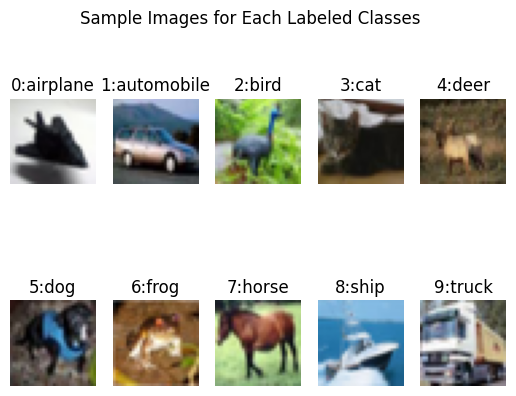

In [17]:
plotImages_Dataset(training_data, classLabel, nRows=2, nCols=5)

**07 -> Hyperparameters**

In [18]:
# Note: Use image as input in LSTM
# imgSize(3, 32, 32) -> (Channel, Row/Height, Col/Width) -> need squeeze image as (32,32)
# View an image as a sample with 1 time_step
in_channels = 3
img_width = 32
img_height = 32
input_size = in_channels*img_width*img_height    # feature size
sequence_length = 1    # rowSize/sample_Size/Time_Steps -> !!(Max Sentence Length)!!
                       # For image processing, it is just "1"
hidden_size = 256      # LSTM unit has a hidden layer and its size define here
num_layers = 2         # stacking LSTM_unit to LSTM_unit vertically (Depth of the network, current LSTM_unit is the next LSTM_unit's input)
num_classes = 10
learning_rate = 1e-3
batch_size = 64
epochs = 6

**08 -> Prepare dataloader and print some basic info on each dataset**

In [19]:
train_dataloader = DataLoader(training_data, batch_size=batch_size)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)

printInfo_DataLoader(train_dataloader, 'Training DataSet')
printInfo_DataLoader(valid_dataloader, 'Validating DataSet')

>>>  Training DataSet  <<<
Total Number of Samples: 50000
Total Number of Batches: 782
Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64
--------------------------------------------------
>>>  Validating DataSet  <<<
Total Number of Samples: 10000
Total Number of Batches: 157
Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64
--------------------------------------------------


**09 -> Setup Model and View Basic Layer Info**

In [20]:
model = Custom_BiLSTM(input_size, sequence_length, hidden_size,
                    num_layers,  num_classes, device).to(device)
summary(model, (batch_size, in_channels, img_width, img_height))

Layer (type:depth-idx)                   Output Shape              Param #
Custom_BiLSTM                            [64, 10]                  --
├─Flatten: 1-1                           [64, 3072]                --
├─LSTM: 1-2                              [64, 1, 512]              8,396,800
├─Linear: 1-3                            [64, 10]                  5,130
Total params: 8,401,930
Trainable params: 8,401,930
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 537.72
Input size (MB): 0.79
Forward/backward pass size (MB): 0.27
Params size (MB): 33.61
Estimated Total Size (MB): 34.66

**10 -> Loss function and optimizer setup**

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**11 -> Train model under n epochs**

In [22]:
epoch_metrics, best_valid_loss = train_model_under_n_epochs(train_dataloader,
                                                           valid_dataloader,
                                                           epochs,
                                                           model,
                                                           loss_fn,
                                                           optimizer,
                                                           device)

 >>> Model Training with 6 epochs <<<
epoch: 0
batch#: 000 batch_loss: 2.299636  [   64/50000]
batch#: 100 batch_loss: 1.758642  [ 6464/50000]
batch#: 200 batch_loss: 1.433735  [12864/50000]
batch#: 300 batch_loss: 1.801439  [19264/50000]
batch#: 400 batch_loss: 1.671923  [25664/50000]
batch#: 500 batch_loss: 1.672836  [32064/50000]
batch#: 600 batch_loss: 1.712036  [38464/50000]
batch#: 700 batch_loss: 1.662107  [44864/50000]
batch#: 781 batch_loss: 1.944046  [50000/50000]
epoch 0  -> training and validation results
train_loss: 1.64863, train_acc: 41.117%
valid_loss: 1.52438, valid_acc: 46.079%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch: 1
batch#: 000 batch_loss: 1.437888  [   64/50000]
batch#: 100 batch_loss: 1.654845  [ 6464/50000]
batch#: 200 batch_loss: 1.238469  [12864/50000]
batch#: 300 batch_loss: 1.597537  [19264/50000]
batch#: 400 batch_loss: 1.590808  [25664/50000]
batch#: 500 batch_loss: 1.526962  [32064/50000]
batch#: 600 batch_loss: 1.560715  [38464/50000]
b

**References:**


1.   https://www.youtube.com/watch?v=6QjPmgcsLLs
2.   https://www.youtube.com/watch?v=Gl2WXLIMvKA&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=5
3.   https://colah.github.io/posts/2015-08-Understanding-LSTMs/
4.   https://www.gabormelli.com/RKB/Bidirectional_LSTM_%28BiLSTM%29_Training_Task
5.   https://medium.com/@anishnama20/understanding-bidirectional-lstm-for-sequential-data-processing-b83d6283befc


